<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Viscous flow past a stationary airfoil

In this notebook, we will solve the Navier-Stokes equations for the flow past a stationary airfoil. Although the body is stationary and the freestream flow is constant, the flow itself will be unsteady. This is because we assume that the flow starts at rest and then suddenly turns on at t = 0. We assume that there are no walls near the airfoil---it is called an *external flow*.

We will assume that the flow is two-dimensional. For this reason, we are relatively limited in the range of Reynolds numbers we will study: essentially, Re = 1000 is about as large as we are prepared to go.

The tools here allow you to set up a wide variety of body shapes, including airfoils, but also circles, rectangles, flat plates, or more abstract shapes.

### First, set up the environment

In [1]:
using MAE150A

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/MAE150A/A9IAL.ji for MAE150A [a017625c-406c-46ee-99d6-0fac6062339e]
└ @ Base loading.jl:1240


In [2]:
pyplot()
initialize_environment()

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


In [11]:
using DelimitedFiles

### Solve flow past a stationary airfoil

Set the flow parameters

In [3]:
Re = 500; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the grid cell spacing

In [4]:
Δx = 0.01

0.01

Open an airfoil data file

In [12]:
pts, header = readdlm("airfoils/naca4415.dat",Float64,header=true)

([1.0 0.0; 0.99893 0.00039; … ; 0.99893 -0.00011; 1.0 0.0], AbstractString["NACA" "4415"])

In [13]:
body = SplinedBody(pts,Δx);

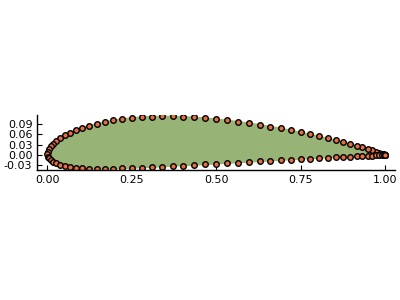

In [14]:
plot(body)
scatter!(pts[:,1],pts[:,2])

Transform the body with a specified initial position and orientation.

In [15]:
cent = (-0.5,0.0)
α = -10π/180 #-π/3 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Basic pointwise-specified body with 206 points
   Current position: (-0.5,0.0)
   Current angle (rad): -0.17453292519943295


Set up the domain

In [16]:
xlim = (-1.0,4.0)
ylim = (-1.0,1.0)

(-1.0, 1.0)

Plot the body in the flow domain, just to make sure it looks as expected

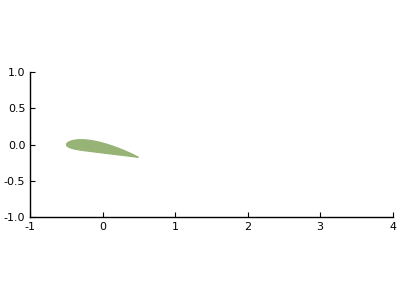

In [17]:
plot(body,xlim=xlim,ylim=ylim)

### Now set up the system

Set up the system and solver here

In [18]:
solver, sys, state0, f = initialize_ns_solver(Re,U∞,Δx,xlim,ylim,body)

(Order-3 IF-HERK integrator with
   State of type Nodes{Dual,504,208,Float64}
   Force of type VectorData{206,Float64}
   Time step size 0.005
, Navier-Stokes system on a grid of size 504 x 208, Dual nodes in a (nx = 504, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 504, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Initialize the state vector

### Advance the system

Set the time range to integrate over.

In [20]:
tf = 6
T = sys.Δt:sys.Δt:tf

0.005:0.005:6.0

In [21]:
t = 0.0
state0 .= 0.0
state = deepcopy(state0)
nothing

Initialize the storage of solution data

In [22]:
# integrated force components on the body
fx = Float64[]
fy = Float64[]
thist = Float64[]

# state vector data
tmin_store = 0.0
tmax_store = 100.0
tsample = 0.1
S = StorePlan(tmin_store,tmax_store,tsample,state,f,t,htype=RegularHistory)
data_history = initialize_storage(S)
nothing

Advance the solution. This will take a few minutes, usually.

In [23]:
@time for iter in eachindex(T)
    global t, state, f = solver(t,state)
    
    store_data!(data_history,t,S,deepcopy(state),deepcopy(f),t)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    
end
println("solution completed through time t = ",t)

159.356233 seconds (6.13 M allocations: 58.389 GiB, 5.65% gc time)
solution completed through time t = 5.999999999999894


Save the current solution data in a file, if desired

In [ ]:
#save_ns_solution("NACA4415_5deg.jld",sys,body,state,f)

#### Plotting

In [24]:
xg, yg = coordinates(state,sys.grid)

(-1.0150000000000001:0.01:4.015, -1.035:0.01:1.035)

In [309]:
iplot = length(data_history[1]) # index of time step for plotting
u, ω, ψ, Cp = get_flowfield(data_history[1][iplot],data_history[2][iplot],sys);
nothing

Plot the vorticity field

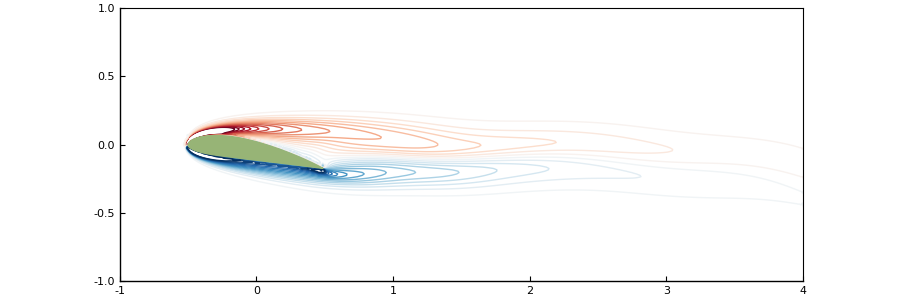

In [27]:
plot(xg,yg,ω,levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15),ylim=(-1,1),xlim=(-1,4),size=(900,300))
plot!(body)

Plot the streamlines, with the stagnation streamline identified in red

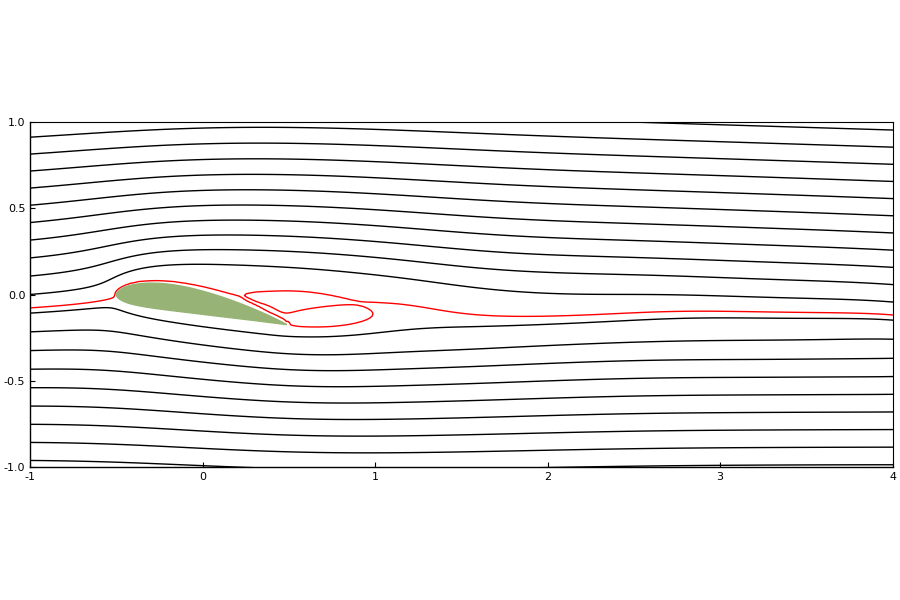

In [43]:
plot(xg,yg,ψ,levels=range(-1,2,length=31), color = :black, ylim = (-1,1),xlim = (-1,4),size=(900,600))
plot!(xg,yg,ψ,levels=[0.228], color = :red, ylim = (-1,1),xlim = (-1,4),size=(900,600))
plot!(body)

Plot lift and drag coefficient

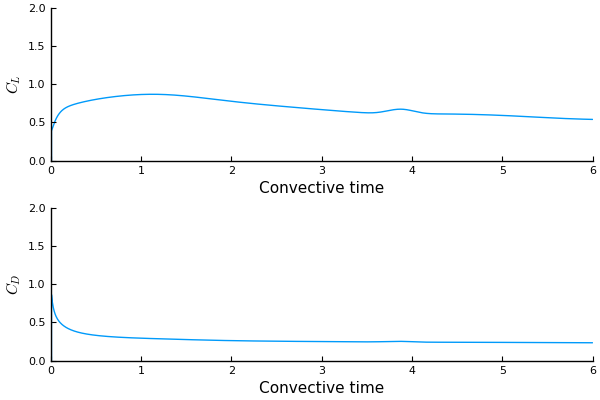

In [362]:
CL = 2*fy
CD = 2*fx
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,CL,xlim=(0,6),ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,CD,xlim=(0,6),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

The steady-state values of lift coefficient and drag coefficient:

In [363]:
CL[end]

0.5400709060557755

In [364]:
CD[end]

0.23424778593721776

### Look at particle trajectories
Let's inspect a few trajectories of particles, released from different points.

In [106]:
xu,yu,xv,yv = coordinates(u,sys.grid)
ufcn, vfcn = interpolatable_field(xu,yu,xv,yv,u);

We will select two initial locations to track the particles from. These two locations are purposefully chosen so that they lie on either side of a separation point.

In [359]:
x0 = [[-1.0,-0.072],[0.45,-0.09]]
Tmax = 50.0
Δt = 0.001
sol = compute_trajectory(u,sys,x0,Tmax,Δt);

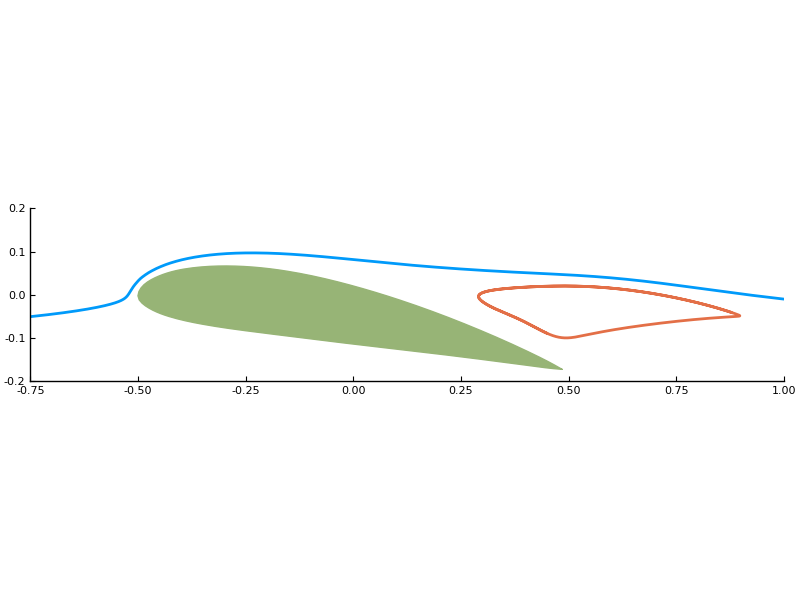

In [360]:
plot(sol[1][1,:],sol[1][2,:],linewidth=2,xlim=(-0.75,1.0),ylim=(-0.2,0.2))
for j in 2:length(sol)
    plot!(sol[j][1,:],sol[j][2,:],linewidth=2)
end
plot!(body,size=(800,600))

The trajectories shown above clearly reveal that the flow is separating from the airfoil somewhere in the middle. We would like to identify the **separation point**. Since this is a point that the streamline is effectively "leaving from", it is hard to locate by guessing and then advancing forward in time.

Instead, let us track particle trajectories **backward** in time. This is equivalent to advancing them by the *negative* of the velocity field. This allows us to find out a little bit more effectively what is happening near the separation point. In this version, we choose final points, rather than initial points.

In [361]:
# Some final points
x0 = [[1.0,0.075],[1.0,-0.03],[1.0,-0.0448],[1.0,-0.0449],[1.0,-0.047],[1.0,-0.05],[0.5,0.01],[0.75,-0.075]] #[0.5,0.02],[0.5,0.0]]

Tmax = 60.0
Δt = 0.001
sol = compute_trajectory(-u,sys,x0,Tmax,Δt);

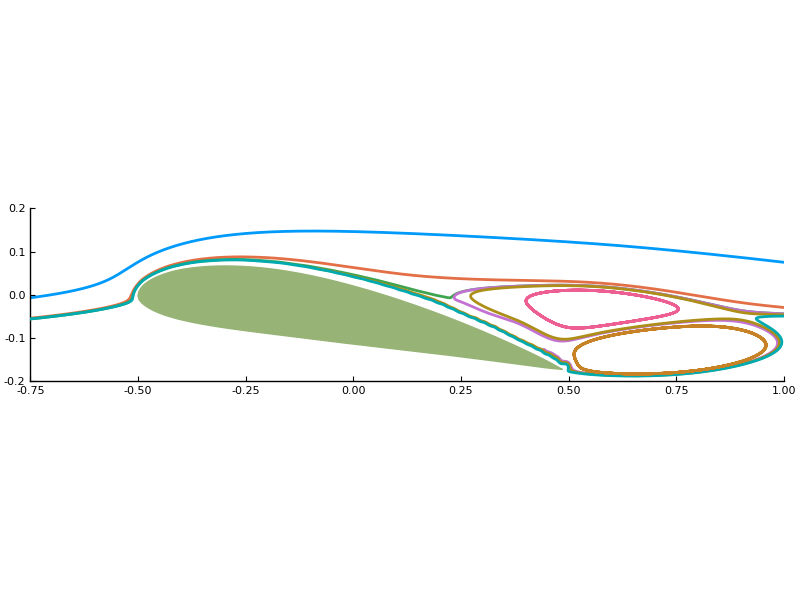

In [307]:
plot(sol[1][1,:],sol[1][2,:],linewidth=2,xlim=(-0.75,1),ylim=(-0.2,0.2))
for j in 2:length(sol)
    plot!(sol[j][1,:],sol[j][2,:],linewidth=2)
end
plot!(body,size=(800,600))

**Homework problem:** Do the same for two other angles of attack, e.g. 0 degrees and 5 degrees. Make plots of your results, with these critical streamlines identified as completely as possible, including stagnation points. What happens to the stagnation point's location as angle of attack increases?

### Velocity profles
What does the velocity profile look like at different points along the airfoil? Let us inspect this by choosing a few locations:

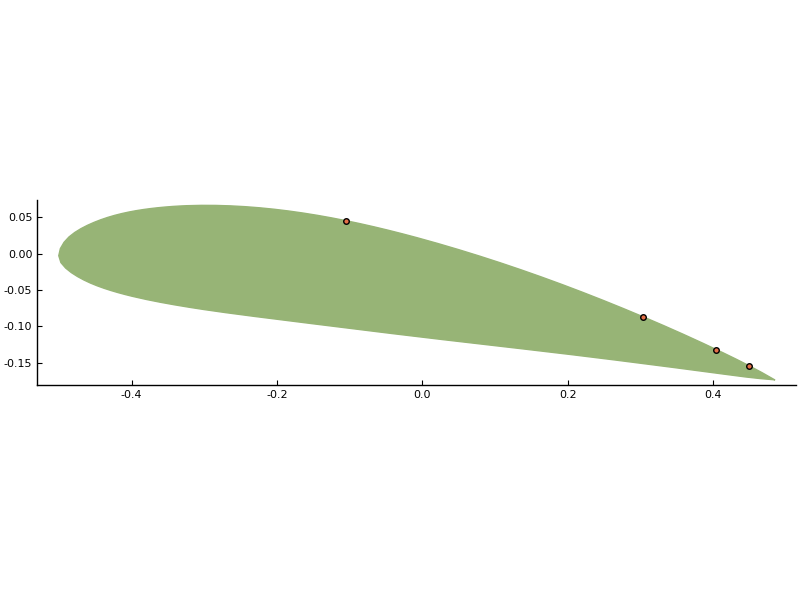

In [356]:
isamp = [5,10,21,64]
plot(body,size=(800,600))
scatter!(body.x[isamp],body.y[isamp])

Let's plot the profiles

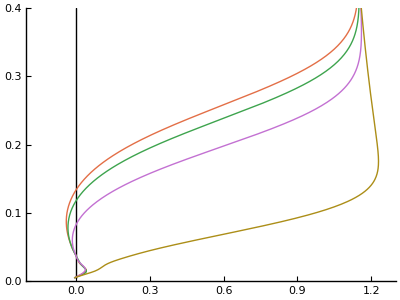

In [355]:
ysamp_base = range(Δx/2,0.4,length=401)

ps = plot(zero(ysamp_base),ysamp_base,color=:black)

for samppt in 1:4
    ysamp = ysamp_base .+ body.y[isamp[samppt]]
    plot!(ps,ufcn.(body.x[isamp[samppt]],ysamp),ysamp_base,xlim=(-0.2,1.3),ylim=(0.0,0.4))
end
plot(ps)

Notice that the profiles show flow reversal near the trailing edge of the airfoil.